Files already downloaded and verified
Files already downloaded and verified
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
1 / 250 epoch: 0 | Loss: 4.804 | Acc: 2.000% (4/200)
2 / 250 epoch: 0 | Loss: 4.796 | Acc: 2.000% (8/400)
3 / 250 epoch: 0 | Loss: 4.787 | Acc: 1.667% (10/600)
4 / 250 epoch: 0 | Loss: 4.783 | Acc: 1.375% (11/800)
5 / 250 epoch: 0 | Loss: 4.775 | Acc: 1.200% (12/1000)
6 / 250 epoch: 0 | Loss: 4.771 | Acc: 1.417% (17/1200)
7 / 250 epoch: 0 | Loss: 4.755 | Acc: 1.429% (20/1400)
8 / 250 epoch: 0 | Loss: 4.747 | Acc: 1.438% (23/1600)
9 / 250 epoch: 0 | Loss: 4.736 | Acc: 1.444% (26/1800)
10 / 250 epoch: 0 | Loss: 4.723 | Acc: 1.450% (29/2000)
11 / 250 epoch: 0 | Loss: 4.714 | Acc: 1.636% (36/2200)
12 / 250 epoc

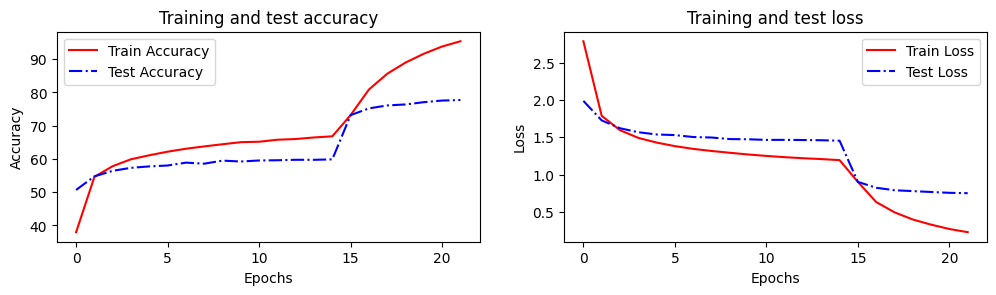

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision import models
from torchvision.models.resnet import resnet18
from torchvision.transforms.transforms import Resize
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) 
])
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=200, shuffle=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=200, shuffle=False)


# Training
def train(net, train_epoch, is_second_train):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    if not is_second_train:
        optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    else:
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    for batch_index, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to('cuda'), targets.to('cuda')
        optimizer.zero_grad()
        outputs = net(torch.squeeze(inputs, 1)) 
        loss = nn.functional.nll_loss(outputs, targets)
        loss.backward()
        optimizer.step() 
        train_loss += loss.item()   #?
        _, predicted = outputs.max(1)  
        total += targets.size(0) 
        correct += predicted.eq(targets).sum().item()
        Loss = train_loss/(batch_index+1)
        Acc = 100.*correct/total
        print(batch_index+1,'/', len(train_loader),'epoch: %d' % train_epoch, '| Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (Loss, Acc, correct, total))
    return Loss, Acc

def evaluate(net, test_epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_index, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to('cuda'), targets.to('cuda')
            outputs = net(torch.squeeze(inputs, 1)) 
            # outputs = net(c.view(1, -1))
            loss = nn.functional.nll_loss(outputs, targets)
            test_loss += loss.item() # accumulate all loss in one epoch
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            Loss = test_loss/(batch_index+1)
            Acc = 100.*correct/total
            print(batch_index+1,'/', len(train_loader),'epoch: %d' % test_epoch, '| Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (Loss, Acc, correct, total))
        return Loss, Acc


def acc_line(Train_loss, Train_acc, Test_loss, Test_acc):
    # 绘制acc和loss曲线
    epochs = range(len(Train_acc))  # Get number of epochs

    # 创建一个图形，包含两行两列的子图
    plt.figure(figsize=(12, 6))

    # 第一个子图：训练和测试准确度曲线
    plt.subplot(2, 2, 1)
    plt.plot(epochs, Train_acc, 'r', linestyle='-')
    plt.plot(epochs, Test_acc, 'b', linestyle='dashdot')
    plt.title('Training and test accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train Accuracy", "Test Accuracy"])

    # 第二个子图：训练和测试损失曲线
    plt.subplot(2, 2, 2)
    plt.plot(epochs, Train_loss, 'r', linestyle='-')
    plt.plot(epochs, Test_loss, 'b', linestyle='dashdot')
    plt.title('Training and test loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train Loss", "Test Loss"])

    # 显示图形
    plt.show()


def main():
    Resnet = models.resnet18(pretrained=True) 
    #迁移学习
    for param in Resnet.parameters(): #Frozen
        print(param.name)
        param.requires_grad = False
    fc_inputs = Resnet.fc.in_features 
    Resnet.fc = nn.Sequential(
        nn.Linear(fc_inputs, 100),
        nn.LogSoftmax(dim=1)
    )
    Resnet.to('cuda')
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    for epoch in range(15):
        Loss, Acc = train(Resnet, epoch, False)
        train_loss.append(Loss)
        train_acc.append(Acc)
        print('begin test')
        torch.save(Resnet.state_dict(), './resnet18cifar100_1.pkl')
        Loss, Acc = evaluate(Resnet, epoch)
        test_loss.append(Loss)
        test_acc.append(Acc)

    # round 2
    Resnet = models.resnet18(pretrained=False)
    fc_inputs = Resnet.fc.in_features 
    Resnet.fc = nn.Sequential(
        nn.Linear(fc_inputs, 100),
        nn.LogSoftmax(dim=1)
    )
    Resnet.to('cuda')
    Resnet.load_state_dict(torch.load('./resnet18cifar100_1.pkl')) 
    model = Resnet.modules()
    for p in model:
        if not isinstance(p, torch.nn.Linear or torch.nn.Conv2d):
            print(p.__class__.__name__)
            p.requires_grad = False
        else:
            p.requires_grad = True


    for epoch in range(7):
        Loss, Acc = train(Resnet, epoch+15, True)
        train_loss.append(Loss)
        train_acc.append(Acc)
        torch.save(Resnet.state_dict(), './resnet18cifar100_2.pkl')
        print('begin test')
        Loss, Acc = evaluate(Resnet, epoch+15)
        test_loss.append(Loss)
        test_acc.append(Acc)

    # plot
    acc_line(train_loss, train_acc, test_loss, test_acc)

if __name__ == "__main__":
    main()